## Тема 2. (Продолжение) Робастная сглаживающая аппроксимация.

In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy

default_dpi = mpl.rcParamsDefault['figure.dpi']
factor = 1
mpl.rcParams['figure.dpi'] = default_dpi * factor

### Функции вычисления коэффициентов разложения

In [58]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastReg (x, y, m, alpha):
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastRobust (x, y, m):
    global G, Phi
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    dist = 1.5
    
    yr = y @ E 
    
    eps = 0.001
    
    # итерационный процесс
    
    print ()
    print ('Итерационный процесс')
    print ()
    
    for it in range (0, 10):
    
        ait = a  
          
        PhiA = Phi @ a
    
        res = Phi @ a - yr        
          
        for i in range (0, n):
            #print ('it*', it,  y[10], PhiA[i]-dist)
            if (res[i]>dist):
                yr[i] = PhiA[i]-dist
                #print ('it+', it,  y[10], PhiA[i]-dist)
            if (res[i]<-dist):
                yr[i] = PhiA[i]+dist
                #print ('it-', it,  y[10], PhiA[i]-dist)
                    
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            print ()
            break 
                
    return a


def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

### Функция вычисления погрешности аппроксимации

In [59]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

def R2 (x, y, Coefs):
    PolynomValue = np.zeros(len(x))
    
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)    
      
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return R2

### Формирование набора данных

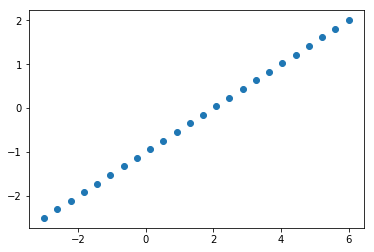

In [60]:
xleft = -3
xright = 6
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))
yf = -1. + 0.5*x
plt.plot (x,yf, 'o')

### Зашумление данных

5.0


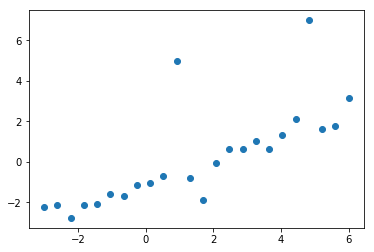

In [64]:
Delta = 0.5 * np.random.randn(len(x))
y = yf + Delta
y_av = np.sum(y)/len(x)

y [10] = 5.
y [20] = 7.

plt.plot (x, y, 'o')

print (y[10])

### Построение аппроксимационного полинома 

Коэффициенты [-0.79302931  0.65858136]
Числа обусловленности матриц G и Phi 13.200833358126783 3.633295110244525


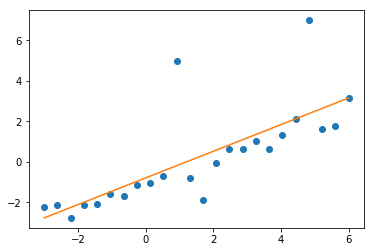

In [65]:
m = 1

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты', PolynomCoefs)

cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Числа обусловленности матриц G и Phi', cond, condPhi)

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)

### Робастная аппроксимация


Итерационный процесс

iteration 0 [-0.97816052  0.61285125] 0.09534779478988513
iteration 1 [-0.99415953  0.60594188] 0.008713604589527081
iteration 2 [-0.99585847  0.60508418] 0.0009515847458757414

Коэффициенты [-0.99585847  0.60508418]
Числа обусловленности матриц G и Phi 13.200833358126783 3.633295110244525


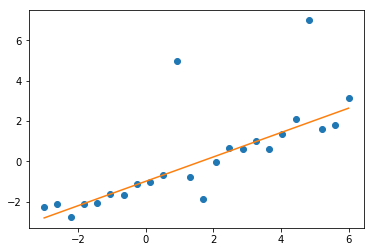

In [66]:
m = 1

PolynomCoefs = SqLeastRobust (x, y, m)
print ('Коэффициенты', PolynomCoefs)

cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Числа обусловленности матриц G и Phi', cond, condPhi)

PolynomValue = np.zeros(len(x))

for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue)